<a href="https://colab.research.google.com/github/utkarshsharma00/Algo_Ds_Notes/blob/master/Sentiment%20Analysis/main_bi_lstm_glove_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import os

# Dataset Loading
'''
folder = 'aclImdb'
labels = {'pos': 1, 'neg': 0}
df = pd.DataFrame()

for f in ('test', 'train'):    
    for l in ('pos', 'neg'):
        path = os.path.join(folder, f, l)
        for file in os.listdir (path) :
            with open(os.path.join(path, file),'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]],ignore_index = True)
            
df.columns = ['review', 'sentiment']
df.to_csv('movie_data_lstm.csv', index = False, encoding = 'utf-8')
'''

df = pd.read_csv('/content/drive/My Drive/QUB/Research/movie_data_lstm.csv', encoding = 'utf-8')
df.head(10)

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1
5,"I saw this film on September 1st, 2005 in Indi...",1
6,"Maybe I'm reading into this too much, but I wo...",1
7,I felt this film did have many good qualities....,1
8,This movie is amazing because the fact that th...,1
9,"""Quitting"" may be as much about exiting a pre-...",1


In [0]:
# Data Preprocessing

import string 
import nltk
import multiprocessing
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
EMB_DIM = 300

review_lines = list()
lines = df['review'].values.tolist()
max_len = 0
#vocab_size = []
for line in lines:
    line = line.replace('<br />', '')
    tokens = word_tokenize(line)
    # Convert to lower case
    tokens = [w.lower() for w in tokens]
    #print(tokens)
    # Remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # Remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    #print(words)
    #print(type(words))
    #Filter out stop words.
    #stop_words = set(stopwords.words('english'))
    #words = [w for w in words if not w in stop_words]
    #print(words)
    if(len(words) > max_len):
        max_len = len(words)
        
    review_lines.append(words)
    
    '''
    for w in words:
        if w not in vocab_size:
            vocab_size.append(w)
            
print(len(vocab_size)) 
'''
print(max_len)
len(review_lines)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
2470


50000

In [0]:
import os

embeddings_index = {}
f = open(os.path.join('', '/content/drive/My Drive/QUB/Research/glove.6B.300d.txt'), encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    foo = np.asarray(values[1:])
    embeddings_index[word] = foo
    
f.close()
print('Found %s word vectors' % len(embeddings_index))

Found 400000 word vectors


In [0]:
# Extension of Data Preprocessing

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

'''
The documents are integer encoded prior to passing them to the Embedding layer. 
The integer maps to the index of a specific vector in the Embedding layer. 
Therefore, it is important to lay the vectors out in the Embedding layer such that the 
encoded words map to the correct vector.
'''

# vectorize the text samples into a 2d integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)


word_index = tokenizer_obj.word_index
print('Found %s unique tokens' % len(word_index))

review_pad = pad_sequences(sequences, maxlen = max_len)
print(review_pad.shape)
sentiment = df['sentiment'].values
print('Shape of review tensor: ', review_pad.shape)
print('Shape of sentiment tensor: ', sentiment.shape)

Found 180164 unique tokens
(50000, 2470)
Shape of review tensor:  (50000, 2470)
Shape of sentiment tensor:  (50000,)


In [0]:
'''
Map embeddings from the loaded glove model for each word to the tokenizer_obj.word_index 
vocabulary and creating a matrix of word vectors.
'''

num_words = len(word_index) + 1
embedding_matrix  = np.zeros((num_words, EMB_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in the embedding matrix will all be zeros
        embedding_matrix[i] = embedding_vector
        
print(num_words)

180165


In [0]:
# Model Creation

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.utils.vis_utils import plot_model


model = Sequential()
embedding_layer = Embedding(num_words, 
                            EMB_DIM, 
                            embeddings_initializer = Constant(embedding_matrix), 
                            input_length = max_len,
                            trainable = False)

model.add(embedding_layer)
model.add(Bidirectional(LSTM(200, activation = 'tanh', 
                             recurrent_activation = 'hard_sigmoid', 
                             use_bias = True, 
                             kernel_initializer = 'glorot_uniform', 
                             recurrent_initializer = 'orthogonal', 
                             bias_initializer = 'zeros', 
                             unit_forget_bias = True, 
                             kernel_regularizer = None, 
                             recurrent_regularizer = None, 
                             bias_regularizer = None, 
                             activity_regularizer = None, 
                             kernel_constraint = None, 
                             recurrent_constraint = None, 
                             bias_constraint = None, 
                             dropout = 0.0, 
                             recurrent_dropout = 0.0, 
                             implementation = 1, 
                             return_sequences = False, 
                             return_state = False, 
                             go_backwards = False, 
                             stateful = False, 
                             unroll = False)))

#model.add(GRU(units = 32, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()
plot_model(model, to_file = 'model_plot_bi_lstm_glove.png', show_shapes = True, show_layer_names = True)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Using TensorFlow backend.
W0731 11:59:20.821037 140426129807232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 11:59:20.853902 140426129807232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 11:59:22.066547 140426129807232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2470, 300)         54049500  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400)               801600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 54,851,501
Trainable params: 802,001
Non-trainable params: 54,049,500
_________________________________________________________________


W0731 11:59:23.164138 140426129807232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0731 11:59:23.191439 140426129807232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0731 11:59:23.198004 140426129807232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# Training 

VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2

indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = sentiment[indices]
num_validation_samples = int(VALIDATION_SPLIT * review_pad.shape[0])
num_test_samples = int(TEST_SPLIT * review_pad.shape[0])

train_size = review_pad.shape[0] - (num_validation_samples + num_test_samples)
X_train_pad = review_pad[0:train_size,:]
y_train = sentiment[0:train_size]
print(X_train_pad.shape)
X_val_pad = review_pad[train_size: (train_size + num_validation_samples), :]
y_val = sentiment[train_size: (train_size + num_validation_samples)]
print(X_val_pad.shape)
X_test_pad = review_pad[(train_size + num_validation_samples):review_pad.shape[0],:]
y_test = sentiment[(train_size + num_validation_samples):review_pad.shape[0]]
print(X_test_pad.shape)

print(indices.shape)

(30000, 2470)
(10000, 2470)
(10000, 2470)
(50000,)


In [0]:
import tensorflow
config = tensorflow.ConfigProto(log_device_placement=True)
from keras.callbacks import EarlyStopping

print('Train...')
es = EarlyStopping(monitor = 'val_acc')

history = model.fit(X_train_pad, y_train, 
                    batch_size = 128, epochs = 3, 
                    validation_data = (X_val_pad, y_val), 
                    verbose = 2, callbacks = [es])

Train...


W0731 11:59:25.327436 140426129807232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 30000 samples, validate on 10000 samples
Epoch 1/3
 - 1876s - loss: 0.5289 - acc: 0.7360 - val_loss: 0.4330 - val_acc: 0.8064
Epoch 2/3
 - 1832s - loss: 0.3869 - acc: 0.8333 - val_loss: 0.3334 - val_acc: 0.8595
Epoch 3/3
 - 1823s - loss: 0.3143 - acc: 0.8671 - val_loss: 0.2949 - val_acc: 0.8786


In [0]:
from sklearn.metrics import accuracy_score

ynew_pred = model.predict(X_test_pad)
ynew_pred[ynew_pred > 0.5] = 1
ynew_pred[ynew_pred < 0.5] = 0
acc = accuracy_score(y_test, ynew_pred, normalize = True)
print(acc)

0.8805


Here in both the Graphs Test (orange color) represents the Validation Set and NOT the Training Set. Forgot to alter the names.

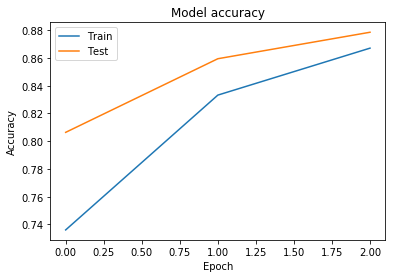

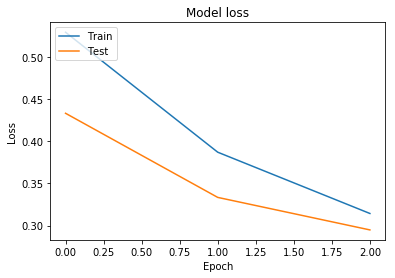

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()